In [104]:
import pandas as pd
from datetime import timedelta
import pytz
import seaborn as sns
import matplotlib.pyplot as plt
from timezonefinder import TimezoneFinder
import numpy as np

In [256]:
df = pd.read_csv('/Users/oussamanaji/Downloads/dolead_vw_extract_2024_10_30.csv')
df['starttimestamp'] = pd.to_datetime(df['starttimestamp'])
df['endtimestamp'] = pd.to_datetime(df['endtimestamp'])
#df.loc[df['agent'] == 'vw', 'local_hour'] = df['starttimestamp'] + timedelta(hours=2)
#df['local_hour'] = df['local_hour'].dt.hour

In [106]:
len(df)

1138

## Dolead

In [257]:
df_us = pd.read_csv('us_zip_codes_to_longitude_and_latitude.csv')
df_us.head()

,geopoint,Daylight_savings_time_flag,Timezone,Longitude,Latitude,State,City,Zip
0,"52.227555,-174.19628",1,-10,-174.19628,52.227555,AK,Atka,99547
1,"51.87957,-176.63675",1,-10,-176.63675,51.879570,AK,Adak,99546
2,"56.605546,-169.55958",1,-10,-169.55958,56.605546,AK,Saint George Island,99591
3,"52.785684,-169.19469",1,-10,-169.19469,52.785684,AK,Nikolski,99638
4,"53.872017,-166.52287",1,-10,-166.52287,53.872017,AK,Unalaska,99685


In [258]:
df_dolead=df[df['agent'] == 'dolead_att'].copy()
df_dolead = df_dolead.merge(df_us[['Zip', 'Timezone', 'Daylight_savings_time_flag']], 
                            left_on='zip_code', 
                            right_on='Zip', 
                            how='left')
df_dolead['heure_offset'] = df_dolead['Timezone'] + df_dolead['Daylight_savings_time_flag']
df_dolead['starttimestamp'] = df_dolead['starttimestamp'] + pd.to_timedelta(df_dolead['heure_offset'], unit='h')
df_dolead['endtimestamp'] = df_dolead['endtimestamp'] + pd.to_timedelta(df_dolead['heure_offset'], unit='h')
df_dolead['local_hour'] = df_dolead['starttimestamp'].dt.hour
df_dolead=df_dolead.drop(columns=['Zip', 'Timezone', 'Daylight_savings_time_flag', 'heure_offset'])
df_dolead.head()

,discussionid,agent,starttimestamp,endtimestamp,callto,duration,picked,zip_code,local_hour
0,CA2ea0921b2e50aa3c05729cac332e7630,dolead_att,2024-10-15 11:04:24.223,2024-10-15 11:04:28.909,18033371229,4.686,False,29130,11
1,CA175ce2872ee3ede611ef4859f70d495a,dolead_att,2024-10-15 11:10:14.815,2024-10-15 11:10:18.945,18033371229,4.130,False,29130,11
2,CA6e9749bbe599976e1144f0619c6f004a,dolead_att,2024-10-15 10:41:17.902,2024-10-15 10:41:22.887,15807401618,4.985,False,74701,10
3,CA510c4a5dd159f9b41eac700f6300a392,dolead_att,2024-10-15 10:46:39.239,2024-10-15 10:46:42.920,15807401618,3.681,False,74701,10
4,CAb258ea9d164dde4cf1cbaece5b32bae7,dolead_att,2024-10-15 11:51:53.959,2024-10-15 11:52:53.267,12294742370,59.308,True,31601,11


In [194]:


premiers_appels = df_dolead.drop_duplicates(subset='callto', keep='first')
taux_decrochage_premier_appel = premiers_appels['picked'].mean()

print(f"Taux de décrochage au premier appel : {taux_decrochage_premier_appel * 100:.2f}%")

numeros_echoues = premiers_appels[~premiers_appels['picked']]['callto'].unique()


rappels_sachant_que_le_premier_appel_echoue = df_dolead[df_dolead['callto'].isin(numeros_echoues) & df_dolead.duplicated(subset='callto', keep='first')]

decroche_parmi_rappels = rappels_sachant_que_le_premier_appel_echoue.groupby('callto')['picked'].apply(lambda x: x.any())

taux_decrochage_apres_echec = decroche_parmi_rappels.mean()
print(f"Taux de décrochage après échec du premier appel : {taux_decrochage_apres_echec * 100:.2f}%")


Taux de décrochage au premier appel : 34.48%
Taux de décrochage après échec du premier appel : 27.68%


In [111]:
taux_decrochage_region = df_dolead.groupby('zip_code')['picked'].mean().reset_index()
taux_decrochage_region.rename(columns={'picked': 'taux_decrochage'}, inplace=True)

# Étape 2 : Calculer la corrélation
correlation = taux_decrochage_region['zip_code'].corr(taux_decrochage_region['taux_decrochage'])

print(f"Corrélation entre le taux de décrochage et la région (zip_code) : {correlation}")

Corrélation entre le taux de décrochage et la région (zip_code) : -0.08147701327485424


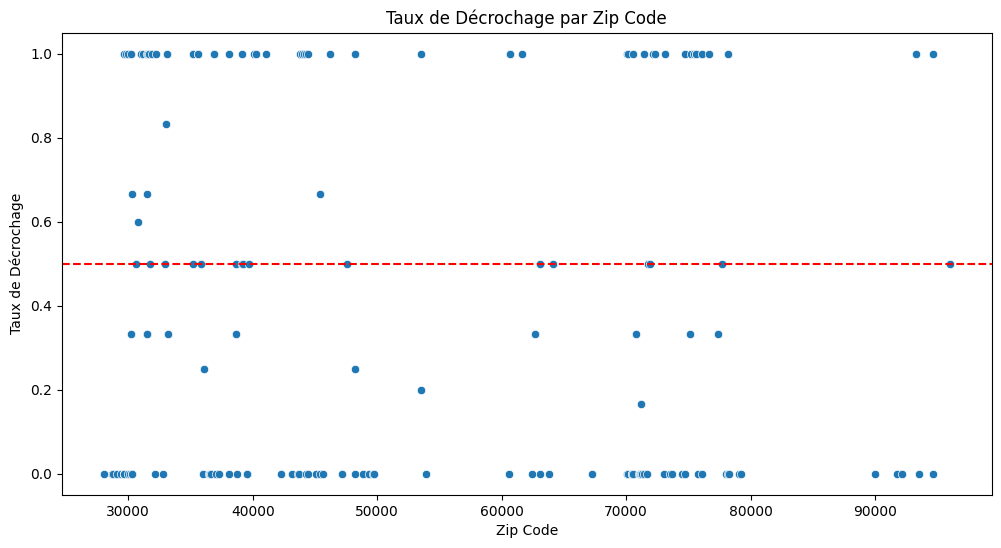

In [112]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=taux_decrochage_region, x='zip_code', y='taux_decrochage')
plt.title('Taux de Décrochage par Zip Code')
plt.xlabel('Zip Code')
plt.ylabel('Taux de Décrochage')
plt.axhline(y=0.5, color='r', linestyle='--')  # Ligne de référence pour 50%
plt.show()

## VW 

In [259]:
df_vw = df[df['agent']=='vw'].copy()
df_vw['starttimestamp']+=timedelta(hours=2)
df_vw['endtimestamp']+=timedelta(hours=2)
df_vw['local_hour'] = df_vw['starttimestamp'].dt.hour   
df_vw.head()

,discussionid,agent,starttimestamp,endtimestamp,callto,duration,picked,zip_code,local_hour
193,CA849fb3f8b6282dda969ae4895bd15c1b,vw,2024-10-22 12:53:04.140,2024-10-22 12:53:36.835,33753183482,32.695,True,13013,12
194,CA5b92d291d0bbe3d551cede999529195d,vw,2024-10-22 12:53:12.739,2024-10-22 12:54:43.247,33780235727,90.508,True,38000,12
195,CAcb26137ffc2ad9f7f7f271f35bff8b46,vw,2024-10-22 12:53:20.681,2024-10-22 12:53:26.525,33768545889,5.844,False,95800,12
196,CAb07344b654b9e857453da96f33f5dbc9,vw,2024-10-22 12:53:20.887,2024-10-22 12:53:28.273,33644747042,7.386,False,73000,12
197,CAe1d78d03e7c056ef98647c484f2d8df9,vw,2024-10-22 12:53:22.942,2024-10-22 12:53:28.208,33744153872,5.266,False,69140,12


In [195]:
premiers_appels = df_vw.drop_duplicates(subset='callto', keep='first')
taux_decrochage_premier_appel = premiers_appels['picked'].mean()

print(f"Taux de décrochage au premier appel : {taux_decrochage_premier_appel * 100:.2f}%")

numeros_echoues = premiers_appels[~premiers_appels['picked']]['callto'].unique()

rappels_sachant_que_le_premier_appel_echoue = df_vw[df_vw['callto'].isin(numeros_echoues) & df_vw.duplicated(subset='callto', keep='first')]

decroche_parmi_rappels = rappels_sachant_que_le_premier_appel_echoue.groupby('callto')['picked'].apply(lambda x: x.any())

taux_decrochage_apres_echec = decroche_parmi_rappels.mean()
print(f"Taux de décrochage après échec du premier appel : {taux_decrochage_apres_echec * 100:.2f}%")

Taux de décrochage au premier appel : 43.32%
Taux de décrochage après échec du premier appel : 46.26%


In [115]:
def categorize_region(zip_code):
    zip_code_str = str(zip_code)
    if zip_code_str.startswith(('75', '77', '78', '91', '92', '93', '94', '95')):
        return 'Région Parisienne'
    elif zip_code_str.startswith(('69', '13', '31', '33', '59', '67', '44')):  # Grandes villes
        return 'Province Grandes Villes'
    else:
        return 'Province Petites Villes'

# Appliquer la fonction pour créer la colonne 'region'
df_vw['region'] = df_vw['zip_code'].apply(categorize_region)

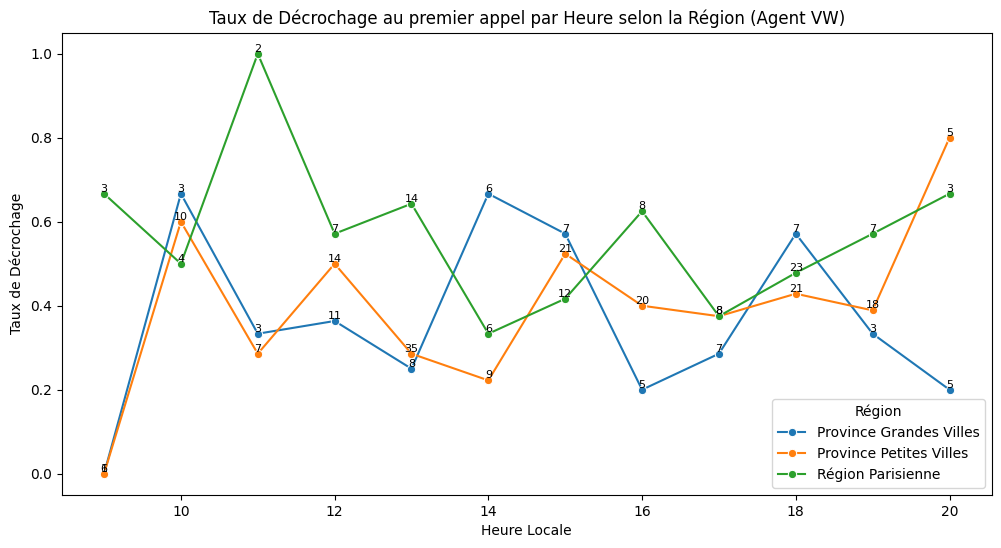

In [116]:
# Calculer le taux de décrochage au premier appel par heure et par région
decrochage_par_heure = df_vw.drop_duplicates(subset='callto', keep='first').groupby(['local_hour', 'region'])['picked'].mean().reset_index()

# Calculer le nombre d'appels par heure et par région
nombre_appels_par_heure = df_vw.drop_duplicates(subset='callto', keep='first').groupby(['local_hour', 'region'])['callto'].count().reset_index()
nombre_appels_par_heure.columns = ['local_hour', 'region', 'nombre_appels']

# Fusionner les deux DataFrames pour avoir les taux et le nombre d'appels
decrochage_par_heure = pd.merge(decrochage_par_heure, nombre_appels_par_heure, on=['local_hour', 'region'])

# Tracer le taux de décrochage par heure et par région
plt.figure(figsize=(12, 6))
sns.lineplot(data=decrochage_par_heure, x='local_hour', y='picked', hue='region', marker='o')
plt.title('Taux de Décrochage au premier appel par Heure selon la Région (Agent VW)')
plt.xlabel('Heure Locale')
plt.ylabel('Taux de Décrochage')
plt.legend(title='Région')

# Ajouter les labels avec le nombre d'appels
for i in range(len(decrochage_par_heure)):
    plt.text(decrochage_par_heure['local_hour'].iloc[i],
             decrochage_par_heure['picked'].iloc[i],
             f"{decrochage_par_heure['nombre_appels'].iloc[i]}",
             horizontalalignment='center',
             verticalalignment='bottom',
             fontsize=8)

plt.show()

In [117]:
# Étape 1 : Grouper par numéro pour obtenir les statistiques souhaitées
appel_stats = (
    df_vw.groupby('callto')
    .agg(
        nombre_appels=('callto', 'size'),
        date_premier_appel=('starttimestamp', 'first'),
        date_dernier_appel=('starttimestamp', 'last'),
        premier_appel_droche=('picked', lambda x: x.iloc[0]),
        dernier_appel_droche=('picked', lambda x: x.iloc[-1]),
        appel_droche_entre=('picked', lambda x: x.iloc[1:-1].any() if len(x) > 2 else False)  # Vérifie un décroché entre le 1er et le dernier appel
        
    )
    .reset_index()
)

# Étape 2 : Visualiser le résultat
appel_stats[(appel_stats['premier_appel_droche']==False)&appel_stats['appel_droche_entre']==True]

,callto,nombre_appels,date_premier_appel,date_dernier_appel,premier_appel_droche,dernier_appel_droche,appel_droche_entre
3,33604497436,6,2024-10-28 14:17:49.294,2024-10-30 13:05:36.673,False,True,True
25,33613475954,4,2024-10-24 13:28:06.618,2024-10-30 16:03:20.946,False,True,True
47,33625366770,3,2024-10-23 16:28:03.661,2024-10-23 20:47:44.888,False,False,True
74,33635446260,3,2024-10-22 18:07:47.007,2024-10-22 19:57:06.420,False,True,True
84,33641042822,5,2024-10-24 15:38:04.930,2024-10-25 19:03:37.840,False,True,True
93,33641833005,4,2024-10-24 13:07:57.382,2024-10-25 12:24:39.506,False,True,True
115,33650478284,4,2024-10-28 20:18:12.216,2024-10-29 20:35:54.627,False,True,True
116,33650723727,4,2024-10-29 14:08:02.294,2024-10-30 16:00:45.253,False,True,True
126,33652529505,4,2024-10-23 16:38:00.693,2024-10-24 11:57:53.601,False,False,True
127,33652607084,4,2024-10-25 13:18:02.684,2024-10-26 19:58:01.659,False,False,True


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



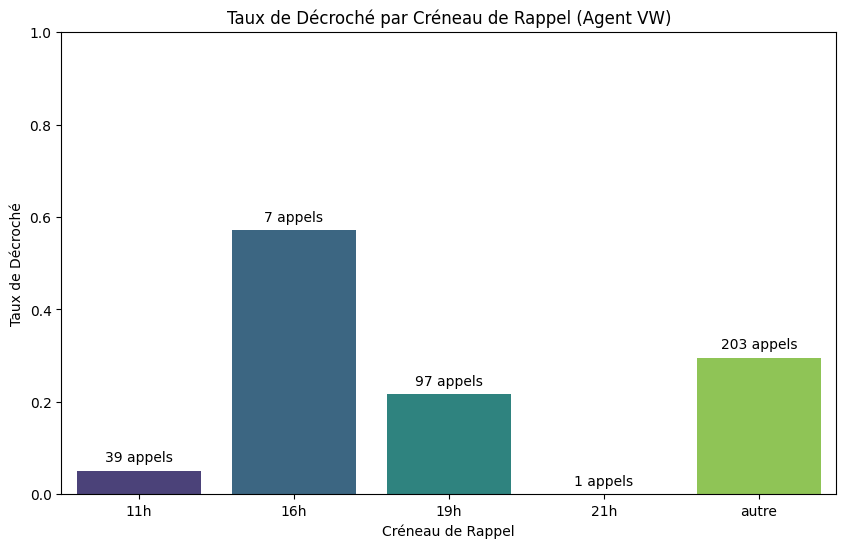

In [118]:
# Étape 1 : Filtrer les rappels (après le premier appel échoué) et créer une colonne pour le créneau de rappel
# Supposons que df_vw est déjà filtré pour inclure uniquement l'agent VW

# On sélectionne les rappels après un premier appel échoué
premiers_appels_echoues = df_vw.drop_duplicates(subset='callto', keep='first')
liste_echecs = premiers_appels_echoues[~premiers_appels_echoues['picked']]['callto']

# Filtrer les appels suivants qui sont des rappels
rappels_df = df_vw[df_vw['callto'].isin(liste_echecs) & (df_vw.duplicated(subset='callto', keep='first'))]

# Créer la colonne 'creneau' basée sur les heures de rappel
conditions = [
    (rappels_df['local_hour'] == 11),
    (rappels_df['local_hour'] == 16),  # Remplacement de 16h par 14h
    (rappels_df['local_hour'] == 19),
    (rappels_df['local_hour'] == 21)
]
choices = ['11h', '16h', '19h', '21h']
rappels_df['creneau'] = np.select(conditions, choices, default='autre')

# Étape 2 : Calculer le taux de décroché par créneau et le nombre total d’appels
taux_decroche_par_creneau = rappels_df.groupby('creneau').agg(
    taux_decroche=('picked', 'mean'),
    nombre_appels=('picked', 'size')
).reset_index()

# Étape 3 : Visualiser les résultats avec annotations pour le nombre total d’appels
plt.figure(figsize=(10, 6))
sns.barplot(data=taux_decroche_par_creneau, x='creneau', y='taux_decroche', palette='viridis')
plt.title('Taux de Décroché par Créneau de Rappel (Agent VW)')
plt.xlabel('Créneau de Rappel')
plt.ylabel('Taux de Décroché')
plt.ylim(0, 1)

# Ajouter les annotations pour chaque barre
for index, row in taux_decroche_par_creneau.iterrows():
    plt.text(index, row['taux_decroche'] + 0.02, f"{row['nombre_appels']} appels", ha='center')

plt.show()

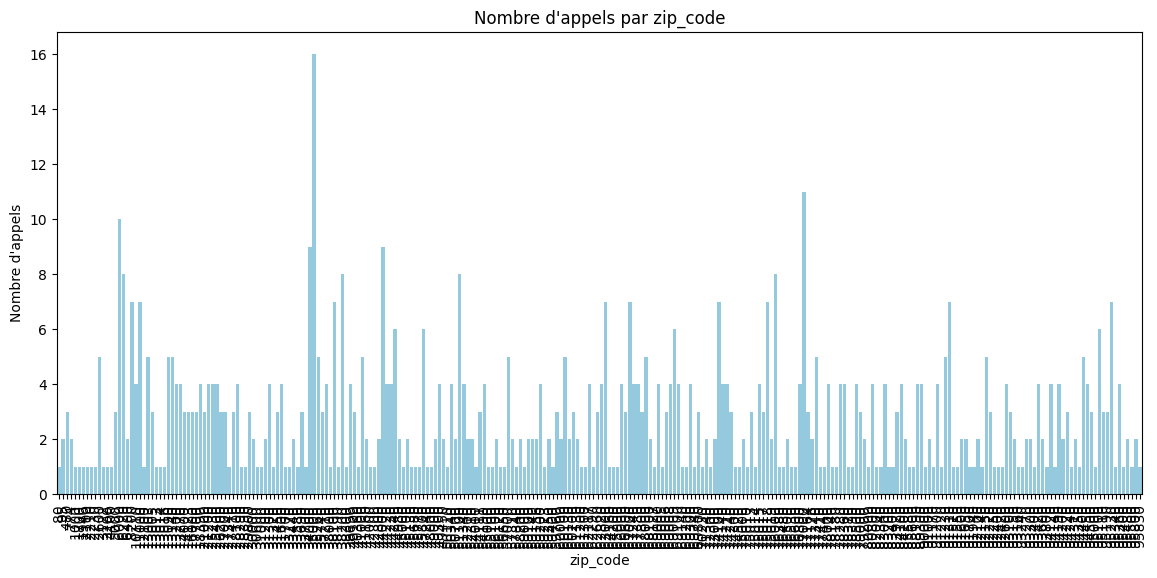

In [165]:
appel_counts = df_vw['zip_code'].value_counts().reset_index()
appel_counts.columns = ['zip_code', 'nombre_appels']

# Tracer le graphique
plt.figure(figsize=(14, 6))
sns.barplot(data=appel_counts, x='zip_code', y='nombre_appels', color="skyblue")
plt.xticks(rotation=90)  # Rotation des labels si nécessaire
plt.title("Nombre d'appels par zip_code")
plt.xlabel("zip_code")
plt.ylabel("Nombre d'appels")
plt.show()

### Encodage

In [183]:
# Calcul du taux de décroché et du nombre d'appels
taux_decrochage = df_vw.groupby('zip_code')['picked'].mean()
nombre_appels = df_vw.groupby('zip_code')['picked'].count()

# Calcul du taux global
taux_global = df_vw['picked'].mean()

# Paramètre de lissage
m = 5  # À ajuster selon vos besoins

# Création d'un DataFrame avec les statistiques
stats_zip = pd.DataFrame({
    'taux_decrochage': taux_decrochage,
    'nombre_appels': nombre_appels
})

# Application du lissage
stats_zip['taux_lisse'] = (stats_zip['nombre_appels'] * stats_zip['taux_decrochage'] + 
                           m * taux_global) / (stats_zip['nombre_appels'] + m)

# Fusion avec le DataFrame d'origine
df_vw = df_vw.merge(stats_zip['taux_lisse'], on='zip_code', how='left')


In [190]:
df_vw.head()

,agent,starttimestamp,endtimestamp,callto,duration,picked,zip_code,local_hour,taux_lisse
0,vw,2024-10-22 12:53:04.140,2024-10-22 12:53:36.835,33753183482,32.695,True,13013,12,0.450500
1,vw,2024-10-22 12:53:12.739,2024-10-22 12:54:43.247,33780235727,90.508,True,38000,12,0.450500
2,vw,2024-10-22 12:53:20.681,2024-10-22 12:53:26.525,33768545889,5.844,False,95800,12,0.386142
3,vw,2024-10-22 12:53:20.887,2024-10-22 12:53:28.273,33644747042,7.386,False,73000,12,0.243285
4,vw,2024-10-22 12:53:22.942,2024-10-22 12:53:28.208,33744153872,5.266,False,69140,12,0.283833


In [196]:
df_vw.head()

,agent,starttimestamp,endtimestamp,callto,duration,picked,zip_code,local_hour
193,vw,2024-10-22 12:53:04.140,2024-10-22 12:53:36.835,33753183482,32.695,True,13013,12
194,vw,2024-10-22 12:53:12.739,2024-10-22 12:54:43.247,33780235727,90.508,True,38000,12
195,vw,2024-10-22 12:53:20.681,2024-10-22 12:53:26.525,33768545889,5.844,False,95800,12
196,vw,2024-10-22 12:53:20.887,2024-10-22 12:53:28.273,33644747042,7.386,False,73000,12
197,vw,2024-10-22 12:53:22.942,2024-10-22 12:53:28.208,33744153872,5.266,False,69140,12


## Concat


In [269]:
df_concat = pd.concat([df_dolead, df_vw],ignore_index=True).set_index('discussionid')
df_concat.head()

,agent,starttimestamp,endtimestamp,callto,duration,picked,zip_code,local_hour
discussionid,,,,,,,,
CA2ea0921b2e50aa3c05729cac332e7630,dolead_att,2024-10-15 11:04:24.223,2024-10-15 11:04:28.909,18033371229,4.686,False,29130,11
CA175ce2872ee3ede611ef4859f70d495a,dolead_att,2024-10-15 11:10:14.815,2024-10-15 11:10:18.945,18033371229,4.130,False,29130,11
CA6e9749bbe599976e1144f0619c6f004a,dolead_att,2024-10-15 10:41:17.902,2024-10-15 10:41:22.887,15807401618,4.985,False,74701,10
CA510c4a5dd159f9b41eac700f6300a392,dolead_att,2024-10-15 10:46:39.239,2024-10-15 10:46:42.920,15807401618,3.681,False,74701,10
CAb258ea9d164dde4cf1cbaece5b32bae7,dolead_att,2024-10-15 11:51:53.959,2024-10-15 11:52:53.267,12294742370,59.308,True,31601,11


In [270]:
df_concat=pd.get_dummies(df_concat, columns=['agent'], drop_first=False, dtype=int)
df_concat['normalized_duration'] = (df_concat['duration'] - df_concat['duration'].min()) / (df_concat['duration'].max() - df_concat['duration'].min())
df_concat['hour_sin'] = np.sin(2 * np.pi * df_concat['local_hour'] / 24)
df_concat['hour_cos'] = np.cos(2 * np.pi * df_concat['local_hour'] / 24)


,callto,picked,zip_code,agent_dolead_att,agent_vw,normalized_duration,hour_sin,hour_cos
discussionid,,,,,,,,
CA2ea0921b2e50aa3c05729cac332e7630,18033371229,False,29130,1,0,0.002781,0.258819,-0.965926
CA175ce2872ee3ede611ef4859f70d495a,18033371229,False,29130,1,0,0.002036,0.258819,-0.965926
CA6e9749bbe599976e1144f0619c6f004a,15807401618,False,74701,1,0,0.003181,0.500000,-0.866025
CA510c4a5dd159f9b41eac700f6300a392,15807401618,False,74701,1,0,0.001435,0.500000,-0.866025
CAb258ea9d164dde4cf1cbaece5b32bae7,12294742370,True,31601,1,0,0.075946,0.258819,-0.965926


In [275]:
stats = df.groupby('zip_code').agg(
    avg_pick_rate=('picked', 'mean'),
    total_calls=('picked', 'count')
).reset_index()
stats

,zip_code,avg_pick_rate,total_calls
0,80,1.000000,1
1,95,0.500000,2
2,480,0.666667,3
3,774,0.500000,2
4,1000,1.000000,1
...,...,...,...
426,95480,0.500000,2
427,95500,1.000000,1
428,95800,0.500000,2
429,95830,0.000000,1


In [ ]:
df_concat=df_concat.drop(columns=['starttimestamp','endtimestamp','duration','local_hour'])
df_concat.head()